#  Backtest de Stratégies Factorielles – Momentum, Value, Size

Ce projet explore la performance de différentes stratégies factorielles (Momentum, Value, Size) sur un univers d'actions américaines.  
Les portefeuilles sont rebalancés mensuellement, et les performances sont comparées à un benchmark égal-pondéré.

---


In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Style des graphiques
plt.style.use("seaborn-v0_8")
pd.options.display.float_format = '{:.2f}'.format


In [9]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'JPM', 'V', 'UNH']
start_date = '2018-01-01'
end_date = '2024-12-31'


In [13]:
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)
data = data['Close'] if isinstance(data.columns, pd.MultiIndex) else data
data = data.dropna(how='all')
data.head()


[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,TSLA,UNH,V
Date,,,,,,,,,,
2018-01-02,40.43,59.45,53.34,87.57,180.43,79.33,4.93,21.37,197.14,108.74
2018-01-03,40.42,60.21,54.25,87.66,183.66,79.70,5.25,21.15,199.20,109.82
2018-01-04,40.61,60.48,54.46,88.92,183.32,80.40,5.28,20.97,200.07,110.23
2018-01-05,41.07,61.46,55.18,88.35,185.83,81.40,5.33,21.11,203.88,112.87
2018-01-08,40.92,62.34,55.38,88.48,187.25,81.48,5.49,22.43,200.34,113.33


In [19]:
# Rendements journaliers
daily_returns = data.pct_change().dropna()

# Prix mensuels (dernier jour de chaque mois)
monthly_prices = data.resample('ME').last()

# Rendements mensuels
monthly_returns = monthly_prices.pct_change().dropna()

# Affichage
monthly_returns.head()


Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,TSLA,UNH,V
Date,,,,,,,,,,
2018-02-28,0.07,0.04,-0.07,-0.00,-0.05,-0.01,-0.01,-0.03,-0.04,-0.01
2018-03-31,-0.06,-0.04,-0.06,-0.05,-0.10,-0.03,-0.04,-0.22,-0.05,-0.03
2018-04-30,-0.02,0.08,-0.02,-0.01,0.08,0.02,-0.03,0.10,0.10,0.06
2018-05-31,0.14,0.04,0.08,-0.02,0.11,0.06,0.12,-0.03,0.02,0.03
2018-06-30,-0.01,0.04,0.03,-0.03,0.01,-0.00,-0.06,0.20,0.02,0.01


In [21]:
# Calcul de la performance sur 12 mois (252 jours boursiers ~ 12 mois)
momentum = monthly_prices.pct_change(periods=12)

# Décalage d'un mois pour éviter le look-ahead bias
momentum = momentum.shift(1)

# Aperçu
momentum.head()


Ticker,AAPL,AMZN,GOOGL,JPM,META,MSFT,NVDA,TSLA,UNH,V
Date,,,,,,,,,,
2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
def get_quantile_portfolio(factor_df, returns_df, quantile=0.8):
    """
    Sélectionne les actions avec le facteur dans le quantile supérieur,
    puis calcule la performance mensuelle moyenne de ce portefeuille.
    """
    # Création d’un masque True/False pour les valeurs dans le top quantile
    signals = factor_df.apply(lambda x: x >= x.quantile(quantile), axis=1)
    
    # Décalage du signal pour éviter le look-ahead bias
    weighted_returns = (returns_df * signals.shift(1)).mean(axis=1)
    
    return weighted_returns


In [25]:
# Portefeuille Momentum (top 20 % des actions)
momentum_portfolio = get_quantile_portfolio(momentum, monthly_returns, quantile=0.8)

# Aperçu des rendements mensuels du portefeuille
momentum_portfolio.head()


Date
2018-01-31     NaN
2018-02-28    0.00
2018-03-31   -0.00
2018-04-30    0.00
2018-05-31    0.00
Freq: ME, dtype: object

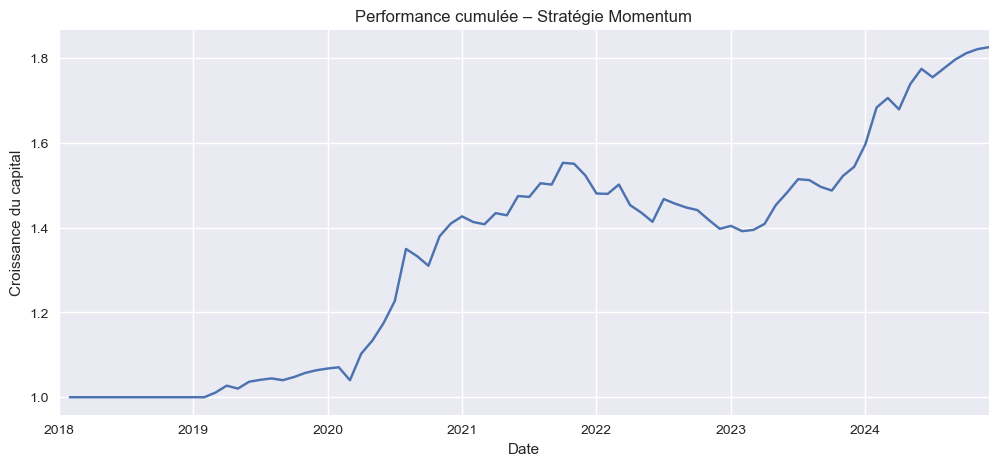

In [29]:
# Croissance cumulée du capital
momentum_perf = (1 + momentum_portfolio).cumprod()

# Affichage du graphique
momentum_perf.plot(figsize=(12, 5), title="Performance cumulée – Stratégie Momentum")
plt.xlabel("Date")
plt.ylabel("Croissance du capital")
plt.grid(True)
plt.show()


In [31]:
# Taux de rendement annuel moyen
annual_return = (1 + momentum_portfolio).prod()**(12 / len(momentum_portfolio)) - 1

# Volatilité annualisée
annual_volatility = momentum_portfolio.std() * np.sqrt(12)

# Sharpe ratio (sans taux sans risque)
sharpe_ratio = annual_return / annual_volatility

# Max drawdown (perte maximale depuis un sommet)
cum_returns = (1 + momentum_portfolio).cumprod()
rolling_max = cum_returns.cummax()
drawdown = cum_returns / rolling_max - 1
max_drawdown = drawdown.min()

# Résumé
stats = pd.Series({
    "Rendement annuel (%)": annual_return * 100,
    "Volatilité annuelle (%)": annual_volatility * 100,
    "Sharpe ratio": sharpe_ratio,
    "Max Drawdown (%)": max_drawdown * 100
})

stats.round(2)


Rendement annuel (%)        8.98
Volatilité annuelle (%)     7.29
Sharpe ratio                1.23
Max Drawdown (%)          -10.39
dtype: float64